In [1]:
from pathlib import Path
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import time
import timm
import random
from collections import OrderedDict
import pandas as pd
import os
import glob
from PIL import Image
import string
import json

In [2]:
source = "/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/raw/iam"

In [3]:
pt_path = os.path.join(source, "rwth_split")
paths = {"train": open(os.path.join(pt_path, "trainset.txt")).read().splitlines(),
         "valid": open(os.path.join(pt_path, "validationset1.txt")).read().splitlines(),
         "test": open(os.path.join(pt_path, "testset.txt")).read().splitlines()}

lines = open(os.path.join(source, "ascii", "words.txt")).read().splitlines()
gt_dict = dict()

In [6]:
for line in lines:
    if (not line or line[0] == "#"):
        continue

    split = line.split()
    if split[1]=='ok':            
        gt_dict[split[0]] = " ".join(split[8::]).replace("|", " ")

dataset = dict()

In [7]:
gt_dict

{'a01-000u-00-00': 'A',
 'a01-000u-00-01': 'MOVE',
 'a01-000u-00-02': 'to',
 'a01-000u-00-03': 'stop',
 'a01-000u-00-04': 'Mr.',
 'a01-000u-00-05': 'Gaitskell',
 'a01-000u-00-06': 'from',
 'a01-000u-01-00': 'nominating',
 'a01-000u-01-01': 'any',
 'a01-000u-01-02': 'more',
 'a01-000u-01-03': 'Labour',
 'a01-000u-01-04': 'life',
 'a01-000u-01-05': 'Peers',
 'a01-000u-02-00': 'is',
 'a01-000u-02-01': 'to',
 'a01-000u-02-02': 'be',
 'a01-000u-02-03': 'made',
 'a01-000u-02-04': 'at',
 'a01-000u-02-05': 'a',
 'a01-000u-02-06': 'meeting',
 'a01-000u-02-07': 'of',
 'a01-000u-02-08': 'Labour',
 'a01-000u-04-00': 'put',
 'a01-000u-04-01': 'down',
 'a01-000u-04-02': 'a',
 'a01-000u-04-03': 'resolution',
 'a01-000u-04-04': 'on',
 'a01-000u-04-05': 'the',
 'a01-000u-04-06': 'subject',
 'a01-000u-06-00': 'Griffiths',
 'a01-000u-06-01': ',',
 'a01-000u-06-02': 'M P',
 'a01-000u-06-03': 'for',
 'a01-000u-06-04': 'Manchester',
 'a01-000u-06-05': 'Exchange',
 'a01-000u-06-06': '.',
 'a01-000x-00-00': '

In [8]:
stopwords = """-,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,a,able,about,across,after,all,almost,also,am,among,an,and,any,are,as,at,be,because,been,but,by,can,cannot,could,dear,did,do,does,either,else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,me,might,most,must,my,neither,no,nor,not,of,off,often,on,only,or,other,our,own,rather,said,say,says,she,should,since,so,some,than,that,the,their,them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,what,when,where,which,while,who,whom,why,will,with,would,yet,you,your""".split(",")

In [99]:
# line = 'a01-000u-02-05'
# split = line.split("-")
# folder = f"{split[0]}-{split[1]}"
# img_path = os.path.join(source, "words", split[0], folder,line)+".png"

In [105]:
# img_path

'/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/raw/iam/words/a01/a01-000u/a01-000u-02-05.png'

In [23]:
# c = cv2.imread('/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/raw/iam/words/p06/p06-052/p06-052-01-05.png')

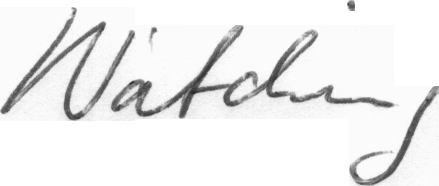

In [24]:
# Image.fromarray(c)

In [9]:
partitions = ['train', 'valid', 'test']

In [10]:
def replace_tokens(text, tokens):
    for t in tokens:
        text = text.replace(t, '')
        
    return text

In [11]:
paths['valid']

['c04-156-02',
 'c04-156-01',
 'c04-156-04',
 'c04-156-06',
 'c04-156-00',
 'c04-156-03',
 'c04-156-05',
 'c04-160-04',
 'c04-160-02',
 'c04-160-01',
 'c04-160-06',
 'c04-160-00',
 'c04-160-08',
 'c04-160-05',
 'c04-160-03',
 'c04-160-07',
 'c04-160-09',
 'c06-083-06',
 'c06-083-04',
 'c06-083-07',
 'c06-083-03',
 'c06-083-00',
 'c06-083-05',
 'c06-083-08',
 'c06-083-02',
 'c06-083-01',
 'd01-024-06',
 'd01-024-02',
 'd01-024-00',
 'd01-024-04',
 'd01-024-05',
 'd01-024-01',
 'd01-024-07',
 'd01-024-03',
 'd01-024-08',
 'd01-056-08',
 'd01-056-04',
 'd01-056-01',
 'd01-056-07',
 'd01-056-05',
 'd01-056-03',
 'd01-056-02',
 'd01-056-00',
 'd01-056-06',
 'd01-056-09',
 'd01-060-00',
 'd01-060-05',
 'd01-060-04',
 'd01-060-07',
 'd01-060-09',
 'd01-060-06',
 'd01-060-03',
 'd01-060-01',
 'd01-060-08',
 'd01-060-02',
 'd03-112-03',
 'd03-112-02',
 'd03-112-06',
 'd03-112-01',
 'd03-112-05',
 'd03-112-08',
 'd03-112-04',
 'd03-112-00',
 'd03-112-07',
 'd04-005-02',
 'd04-005-01',
 'd04-005-

In [12]:
data = []
count = 0
alphabet = string.ascii_lowercase + string.digits + """ "!#$%&\'()*+,./:;<=>?@[\\]^_`{|}~"""

for i in partitions:
    for line in paths[i]:
        i = i.replace("valid","train")
        try:
            split = line.split("-")
            folder = f"{split[0]}-{split[1]}"
            folder_path = os.path.join(source, "words", split[0], folder)
            for img in glob.glob(folder_path+'/{}*'.format(line)):
                label = gt_dict[img.split("/")[-1].replace(".png","")].lower()
                if len(label)==1:
                    continue
                if label in stopwords:
                    continue
                ntexts = [replace_tokens(text, [t for t in text if t not in alphabet]) for text in label]
                data.append({"file":img, "text":"".join(ntexts), "split":i})    
        except KeyError:
            count+=1
            pass

In [13]:
data[:2]

[{'file': '/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/raw/iam/words/a01/a01-000u/a01-000u-04-01.png',
  'text': 'down',
  'split': 'train'},
 {'file': '/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/raw/iam/words/a01/a01-000u/a01-000u-04-00.png',
  'text': 'put',
  'split': 'train'}]

In [10]:
with open("raw/rimes_word.json", 'w') as f:
    json.dump(data, f)

In [12]:
len(data)

35053

In [ ]:
import data_augmentation as da
import json
import os
import numpy as np
from load_washington import *

In [ ]:
augmented_dir = os.path.join("../raw/", 'iam_word_augmentation/')

In [ ]:
with open("../raw/iam_words.json") as f:
    data = json.load(f)

In [ ]:
augmented_data = da.augment_data(data, augmented_dir)

In [16]:
cc = [i for i in data if i['split']=="test"]

In [17]:
len(cc)*50+len(cc)

461601

In [18]:
len(cc)

9051

In [ ]:
# for i in partitions:
#     dataset[i] = {"dt": [], "gt": []}

#     for line in paths[i]:
#         try:
#             split = line.split("-")
#             folder = f"{split[0]}-{split[1]}"

# #             img_file = f"{split[0]}-{split[1]}-{split[2]}.png"
#             img_path = os.path.join(source, "words", split[0], folder)
    
    
#             for img in glob.glob(img_path+'/*'):
#                 dataset[i]['gt'].append(gt_dict[img.split("/")[-1].replace(".png","")])
#                 dataset[i]['dt'].append(img)
#         except KeyError:
#             print(line)
#             pass

In [125]:
source = "data/washington_aug.hdf5"
split = "valid"

dataset = dict()

with h5py.File(source, "r") as f:
    dataset[split] = dict()
    
    dataset[split]['dt'] = np.array(f[split]['dt'])
    dataset[split]['gt'] = np.array(f[split]['gt'])


In [126]:
dataset[split].keys()

dict_keys(['dt', 'gt'])

In [128]:
len(dataset[split]["gt"])

0

In [112]:
dataset[split]['label'] = [1]*len(dataset[split]['dt'])

In [113]:
images = []
gts = []
for i in range(len(dataset[split]['gt'])):
    images.append(dataset[split]['dt'][i])
    while True:            
        r1 = random.randint(0, len(dataset[split]['gt'])-1)
        if i!=r1 or dataset[split]['gt'][i]!=dataset[split]['gt'][r1]:
            break           
            
    gts.append(dataset[split]['gt'][r1])

In [114]:
dataset[split]['dt'] = list(dataset[split]['dt'])
dataset[split]['gt'] = list(dataset[split]['gt'])

In [115]:
dataset[split]['dt'].extend(images)
dataset[split]['gt'].extend(gts)

In [116]:
dataset[split]['label'].extend([0]*len(gts))

In [117]:
len(dataset[split]['label']), len(dataset[split]['gt'])

(1978, 1978)

In [48]:
!pwd

/home/mhamdan/seq2seqAttenHTR/Transformer_ocr


In [118]:
for i in [split]:
    
    with h5py.File("data/washington_aug.hdf5", "a") as hf:
        hf.create_dataset(f"{i}/label", data=np.array(dataset[i]['label']), compression="gzip", compression_opts=9)                
        hf.create_dataset(f"{i}/gt", data=np.array(dataset[i]['gt'], dtype=h5py.special_dtype(vlen=str)), compression="gzip", compression_opts=9)        
        hf.create_dataset(f"{i}/dt", data=dataset[i]['dt'], compression="gzip", compression_opts=9)
        print(f"[OK] {i} partition.")


[OK] valid partition.


In [41]:
no = 55

In [120]:
images[no].T

(128, 256)

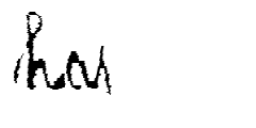

In [119]:
Image.fromarray(images[no].T)

In [43]:
gts[no]

b'and'

In [28]:
dataset[split]['gt'][no]

b'opportunity'

In [25]:
import random

In [56]:
random.random()

0.4071601000269184

In [80]:
img_3 = np.zeros([256,128],dtype=np.uint8)
img_3.fill(255)

In [89]:
img_ = np.zeros([512,128],dtype=np.uint8)
img_.fill(255)

In [116]:
dtimgs = []
for img in dataset[split]['dt']:
    img = np.concatenate([img.T,img_.T], axis=1)        
    dtimgs.append(img.T)

In [82]:
imgs = []
gts = []
for i in range(2000):
    ct = []
    st = ""
    r1 = random.randint(0, 1870)
    r2 = random.randint(0, 1870)
    ct.append(dataset[split]['dt'][r1].T)
    st+=dataset[split]['gt'][r1].decode()
    ct.append(dataset[split]['dt'][r2].T)    
    st = st + " " +dataset[split]['gt'][r2].decode()    
    if random.random() > .5:
        r3 = random.randint(0, 1870)
        ct.append(dataset[split]['dt'][r3].T)
        st = st + " " +dataset[split]['gt'][r3].decode() 
    else:
        ct.append(img_3.T)
        
    img = np.concatenate(ct, axis=1)        
    imgs.append(img.T)
    gts.append(st)


In [67]:
img_3 = np.zeros([256,256,3],dtype=np.uint8)
img_3.fill(255)


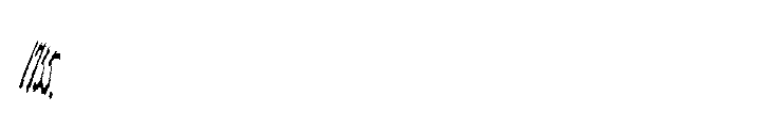

In [106]:
Image.fromarray(dtimgs[0].T)

In [24]:
im = cv2.imread("raw/washington/data/word_images_normalized/272-19-09.png")

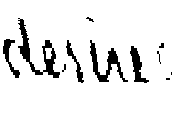

In [25]:
Image.fromarray(im)

In [86]:
dataset[split]['dt'][0].shape, imgs[0].shape

((256, 128), (768, 128))

In [73]:
dataset["train"]["gt"] = list(dataset["train"]["gt"])
dataset["train"]["dt"] = list(dataset["train"]["dt"])

In [74]:
dataset[split]['dt'].extend(imgs)
dataset[split]['gt'].extend(gts)

In [118]:
d={split:{"dt": [], "gt":[]}}

In [98]:
d['train']['dt'] = dtimgs + imgs
d['train']['gt'] = list(dataset["train"]["gt"]) + gts

In [110]:
split

'valid'

In [119]:
d[split]['dt'] = dtimgs 
d[split]['gt'] = list(dataset[split]["gt"])

In [120]:
len(d[split]['dt']),len(d[split]['gt'])

(886, 886)

In [29]:
for i in [split]:
    
    with h5py.File("data/washington_with_label.hdf5", "a") as hf:
        hf.create_dataset(f"{i}/gt", data=np.array(d[i]['gt'], dtype=h5py.special_dtype(vlen=str)), compression="gzip", compression_opts=9)        
        hf.create_dataset(f"{i}/dt", data=d[i]['dt'], compression="gzip", compression_opts=9)
        print(f"[OK] {i} partition.")


NameError: name 'd' is not defined

In [45]:
img.shape

(128, 512)

In [10]:
from PIL import Image

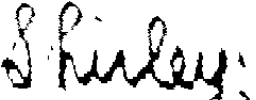

In [22]:
Image.fromarray(dataset[split]['dt'][147][:,:100].T)